In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import warnings
import sys
from baseband import dada

In [2]:
puls = fits.open('J0953+0755_2025_11_16_06_05_31_1p5mins_type_0.dada_intensity.fits')
puls.info()

Filename: J0953+0755_2025_11_16_06_05_31_1p5mins_type_0.dada_intensity.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   ()      
  1  HISTORY       1 BinTableHDU     74   1R x 29C   [24A, 256A, 8A, 8A, 1J, 1I, 1I, 1I, 1D, 1D, 1J, 1D, 1D, 1D, 1D, 1I, 1I, 1I, 1I, 1I, 32A, 32A, 32A, 256A, 32A, 32A, 1I, 32A, 1I]   
  2  SUBINT        1 BinTableHDU     72   172R x 10C   [1D, 1D, 1D, 1D, 1D, 256D, 256E, 256E, 256E, 524288B]   


# READING THE HEADER (KNOW YOUR DATA)

In [3]:
for i, hdu in enumerate(puls):
    print("\n" + "="*60)
    print(f"HDU {i}: {hdu.name}")
    print("="*60)
    hdu.header.totextfile(sys.stdout)


HDU 0: PRIMARY
SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
HDRVER  = '6.7             '   / Header version                                 
FITSTYPE= 'PSRFITS         '   / FITS definition for pulsar data files          
DATE    = '2

In [4]:
sample_time = puls['SUBINT'].header['TBIN']

chan_bw_bin = puls['SUBINT'].header['CHAN_BW']

print("sample_time = " +str( sample_time))


cen_freq = puls['PRIMARY'].header['OBSFREQ']
Band_Width = puls['PRIMARY'].header['OBSBW']

nchan = puls['SUBINT'].header['NCHAN']


sample_time = 0.000248242424242424


In [5]:
start_freq = cen_freq - (Band_Width/2)
end_freq = cen_freq + (Band_Width/2)

In [6]:
data = puls['SUBINT'].data['DATA']

In [7]:
data.shape

(172, 2048, 1, 256)

In [8]:
psr_data = data.reshape(2048*172, 256)

In [9]:
spectra, fbins = psr_data.shape

# SEE THE SPECTRUM (after removing the bandpass)

In [10]:
start_freq, end_freq

(166.75, 183.25)

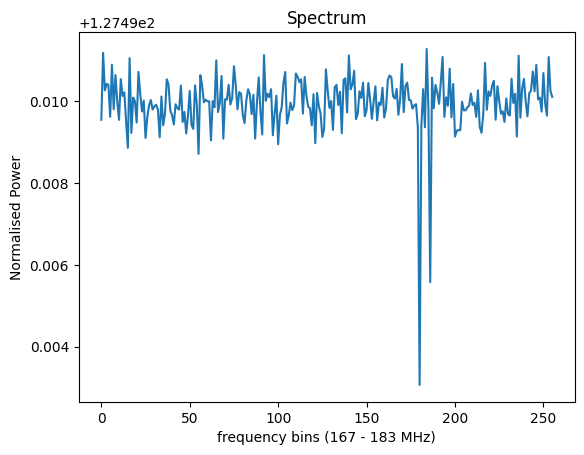

In [11]:
plt.plot(np.mean(psr_data.T, axis = 1));
plt.xlabel("frequency bins (167 - 183 MHz)");
plt.ylabel("Normalised Power");
plt.title("Spectrum");

In [12]:
'''
plt.figure(figsize=(18,4))
plt.subplot(2,1,1)
# Viewing Selected Time Segement .
plt.imshow(psr_data.T[:, :],cmap='jet', aspect='auto', origin='lower', extent = [0*sample_time,spectra*sample_time, start_freq, end_freq]);
plt.xlabel("time in seconds")
plt.ylabel("frequency in MHz")
plt.subplot(2,1,2)
plt.plot(np.mean(psr_data.T[:, :], axis = 0));
plt.margins(0,0)
plt.xticks([])
plt.xlabel("time in seconds")
plt.ylabel("Amplitude")
plt.show()

'''

'\nplt.figure(figsize=(18,4))\nplt.subplot(2,1,1)\n# Viewing Selected Time Segement .\nplt.imshow(psr_data.T[:, :],cmap=\'jet\', aspect=\'auto\', origin=\'lower\', extent = [0*sample_time,spectra*sample_time, start_freq, end_freq]);\nplt.xlabel("time in seconds")\nplt.ylabel("frequency in MHz")\nplt.subplot(2,1,2)\nplt.plot(np.mean(psr_data.T[:, :], axis = 0));\nplt.margins(0,0)\nplt.xticks([])\nplt.xlabel("time in seconds")\nplt.ylabel("Amplitude")\nplt.show()\n\n'

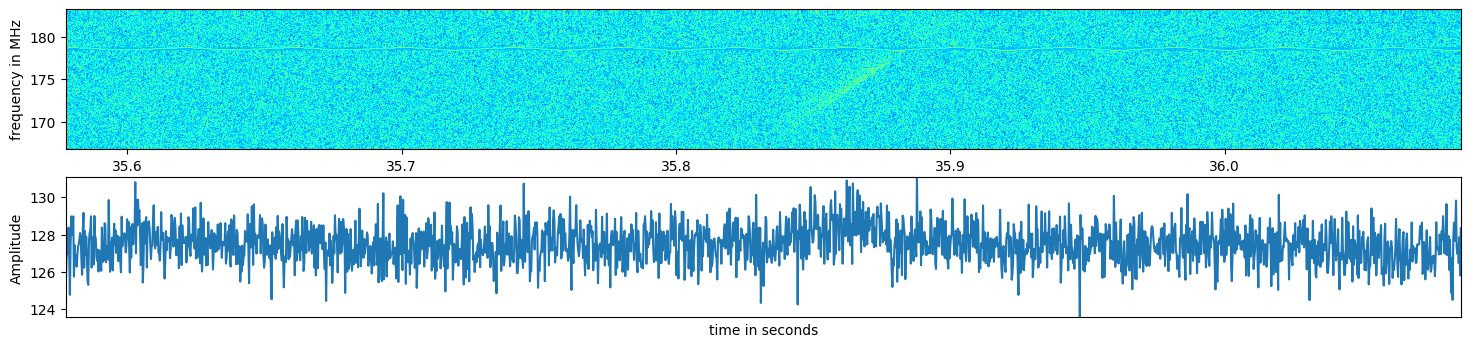

In [13]:
plt.figure(figsize=(18,4))
plt.subplot(2,1,1)
# Viewing Selected Time Segement .
plt.imshow(psr_data.T[:, 143318:145366],cmap='jet', aspect='auto', origin='lower', extent = [143318*sample_time,145366*sample_time, start_freq, end_freq]);
plt.xlabel("time in seconds")
plt.ylabel("frequency in MHz")
plt.subplot(2,1,2)
plt.plot(np.mean(psr_data.T[:, 143318:145366], axis = 0));
plt.margins(0,0)
plt.xticks([])
plt.xlabel("time in seconds")
plt.ylabel("Amplitude")
plt.show()

# DE DESPERSION

In [14]:
def pulsar_ddplan(psr_data, DM):
    def make_frequency_axis(f_center_MHz, bandwidth_MHz, nchan=256):
        df = bandwidth_MHz / nchan
        f_start = f_center_MHz - bandwidth_MHz / 2 + df / 2
        freqs_MHz = f_start + df * np.arange(nchan)
        return freqs_MHz
    def dedispersion_plan(freqs_MHz, DM, f_ref_MHz=None):
        k_DM = 4.148808e3  # MHz^2 pc^-1 cm^3 s

        if f_ref_MHz is None:
            f_ref_MHz = np.max(freqs_MHz)

        delays_sec = k_DM * DM * (
            1.0 / freqs_MHz**2 - 1.0 / f_ref_MHz**2
        )

        return delays_sec

    def delays_to_samples(delays_sec, tsamp):
        return np.rint(delays_sec / tsamp).astype(int)

    def incoherent_dedisperse(data, shifts):
        ntime, nchan = data.shape
        dedispersed = np.zeros_like(data)

        for ch in range(nchan):
            dedispersed[:, ch] = np.roll(
                data[:, ch],
                shifts[ch] 
            )

        return dedispersed

    # Given
    data = psr_data   
    #DM = 2.96927
    tsamp = 0.0002482424242423124  
    f_center = 175     
    bandwidth = 16.5     


    freqs = make_frequency_axis(f_center, bandwidth, nchan=256)

    # Step 2: Dedispersion plan
    delays_sec = dedispersion_plan(freqs, DM)

    # Step 3: Sample shifts
    shifts = delays_to_samples(delays_sec, tsamp)

    # Step 4: Apply dedispersion
    data_dd = incoherent_dedisperse(data, shifts)

    return data_dd

DM = input("GIVE YOUR DM VALUE (between 1.0 to 5.0):")
plt.figure(figsize=(18,6))
plt.subplot(2,1,1)
data = pulsar_ddplan(psr_data, float(DM))
plt.imshow(data.T[:, 143318:145366],cmap='jet', aspect='auto', origin='lower', extent = [143318*sample_time,145366*sample_time, start_freq, end_freq]);
plt.xlabel("time in seconds");
plt.ylabel("frequency in MHz");
f_col_time_series = np.mean(data.T[:, 143318:145366], axis = 0)
plt.grid()

'''
plt.subplot(3,1,2)
plt.plot(f_col_time_series);
plt.xticks([])
plt.margins(0,0)
plt.xlabel("time in seconds")
plt.ylabel("Amplitude")
plt.show()
'''
plt.show()
k = input("Select one of the following off-pulse region (seconds) (1. [35.6, 35.7], 2 [35.7, 35.8], 3 [35.8, 35.9], 4 FULL RANGE) : ")

f_col_time_series_1 = (f_col_time_series-np.mean(f_col_time_series))


if k == 1:
    rms = np.std(f_col_time_series_1[:400])
elif k == 2:
    rms = np.std(f_col_time_series_1[400 : (400*2)])
elif k ==3:
    rms = np.std(f_col_time_series_1[(400*2):(400*3)])
else :
    rms = np.std(f_col_time_series_1[:400*5])
plt.figure(figsize=(18,6));
plt.subplot(2,1,2);
plt.plot(f_col_time_series_1/float(rms));
plt.xticks([])
plt.margins(0,0)
plt.xlabel("time in seconds")
plt.ylabel("Amplitude")
print("MAXIMUM SNR SEEN : " + str(max(f_col_time_series_1/float(rms))))


In [ ]:
DM = input("GIVE YOUR DM VALUE (between 1.0 to 5.0):")
plt.figure(figsize=(18,6))
plt.subplot(2,1,1)
data = pulsar_ddplan(psr_data, float(DM))
plt.imshow(data.T[:, 143318:145366],cmap='jet', aspect='auto', origin='lower', extent = [143318*sample_time,145366*sample_time, start_freq, end_freq]);
plt.xlabel("time in seconds");
plt.ylabel("frequency in MHz");
f_col_time_series = np.mean(data.T[:, 143318:145366], axis = 0)
plt.grid()

'''
plt.subplot(3,1,2)
plt.plot(f_col_time_series);
plt.xticks([])
plt.margins(0,0)
plt.xlabel("time in seconds")
plt.ylabel("Amplitude")
plt.show()
'''
plt.show()
k = input("Select one of the following off-pulse region (seconds) (1. [35.6, 35.7], 2 [35.7, 35.8], 3 [35.8, 35.9], 4 FULL RANGE) : ")

f_col_time_series_1 = (f_col_time_series-np.mean(f_col_time_series))


if k == 1:
    rms = np.std(f_col_time_series_1[:400])
elif k == 2:
    rms = np.std(f_col_time_series_1[400 : (400*2)])
elif k ==3:
    rms = np.std(f_col_time_series_1[(400*2):(400*3)])
else :
    rms = np.std(f_col_time_series_1[:400*5])
plt.figure(figsize=(18,6));
plt.subplot(2,1,2);
plt.plot(f_col_time_series_1/float(rms));
plt.xticks([])
plt.margins(0,0)
plt.xlabel("time in seconds")
plt.ylabel("Amplitude")
print("MAXIMUM SNR SEEN : " + str(max(f_col_time_series_1/float(rms))))


In [49]:
for i in range(8):
    globals()[f"data_{i}"] = data[:,i*32:(i+1)*32]

# PULSE PROFILE FOLDING

In [47]:
import numpy as np
import warnings

def fold_pulsar_data(
    data,
    period,
    tsamp,
    nbin,
    npulses=None,
    check_smearing=True
):
    '''
    Here the def 'fold_pulsar_data' takes data of 2d-array and period for which you are 
    folding the pulsar profile, you should specific the number of bins in the profile, 
    'check_smearing' module will check if the bins requested is more than the tsamp. If so,
    it will produce a messgae and continue with a default value.
    '''
    if data.ndim != 2:
        raise ValueError("data must have shape (ntime, nchan)")

    ntime, nchan = data.shape

    samples_per_period = int(period / tsamp)

    if npulses is not None:
        max_samples = npulses * samples_per_period
        if max_samples > ntime:
            warnings.warn(
                "Requested npulses exceeds data length. "
                "Using all available data."
            )
            max_samples = ntime
    else:
        max_samples = ntime

    samples_per_bin = samples_per_period / nbin

    if check_smearing:
        if samples_per_bin < 1.0:
            warnings.warn(
                f"Severe phase smearing: "
                f"{samples_per_bin:.2f} samples per phase bin (< 1). "
                f"Reduce nbin or tsamp."
            )
        elif samples_per_bin < 2.0:
            warnings.warn(
                f"Moderate phase smearing: "
                f"{samples_per_bin:.2f} samples per phase bin."
            )

    time = np.arange(max_samples) * tsamp
    phase = (time / period) % 1.0
    phase_bins = (phase * nbin).astype(int)

    folded = np.zeros((nbin, nchan))
    counts = np.zeros(nbin)

    for i in range(max_samples):
        b = phase_bins[i]
        folded[b, :] += data[i, :]
        counts[b] += 1

    # Normalize safely
    valid = counts > 0
    folded[valid] /= counts[valid, None]

    profile = folded.mean(axis=1)

    return folded, profile

In [50]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(8):

    folded, profile = fold_pulsar_data(
        globals()[f"data_{i}"],
        period=0.2530654277593,
        tsamp=sample_time,
        nbin=256,
        npulses=320
    )

    # Remove mean and compute RMS
    profile_1 = profile - np.mean(profile)
    rms = np.std(profile_1)

    # Create figure with 2 rows, 1 column
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # ---------- Top panel: raw folded profile ----------
    axs[0].plot(profile, color='k')
    axs[0].set_title(
        f"Folded Profile for Channels {i*64} to {(i+1)*64 - 1}"
    )
    axs[0].set_ylabel("Amplitude")
    axs[0].grid(True)

    # ---------- Bottom panel: SNR-normalized profile ----------
    axs[1].plot(profile_1 / rms, color='b')
    axs[1].set_xlabel("Phase Bins")
    axs[1].set_ylabel("Amplitude (SNR)")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

ValueError: data must have shape (ntime, nchan)

In [19]:
folded_tf_1, profile_1 = fold_pulsar_data(
    data,     # dedispersed (ntime, nchan)
    period=0.253,
    tsamp=sample_time,
    nbin=512
)

/tmp/ipykernel_50067/119966499.py:40: UserWarning: Moderate phase smearing: 1.99 samples per phase bin.
  warnings.warn(


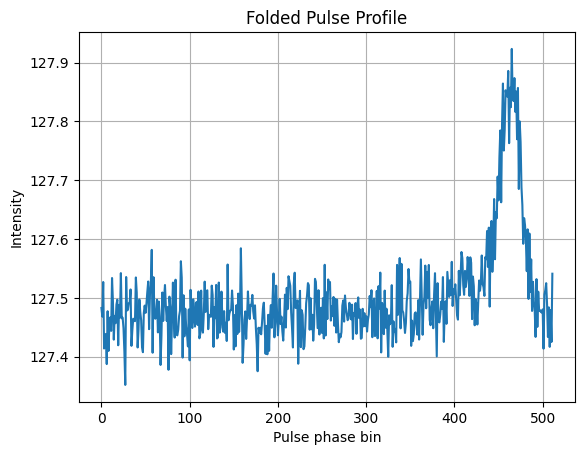

In [20]:
import matplotlib.pyplot as plt

plt.plot(profile_1)
plt.xlabel("Pulse phase bin")
plt.ylabel("Intensity")
plt.title("Folded Pulse Profile")
plt.grid()
plt.show()

# POLARISATION

In [23]:
puls = fits.open('J1921+2153_2025_11_16_15_31_1p5mins_type_0.dada_stokes.fits')
puls.info()

Filename: J1921+2153_2025_11_16_15_31_1p5mins_type_0.dada_stokes.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   ()      
  1  HISTORY       1 BinTableHDU     74   1R x 29C   [24A, 256A, 8A, 8A, 1J, 1I, 1I, 1I, 1D, 1D, 1J, 1D, 1D, 1D, 1D, 1I, 1I, 1I, 1I, 1I, 32A, 32A, 32A, 256A, 32A, 32A, 1I, 32A, 1I]   
  2  SUBINT        1 BinTableHDU     72   172R x 10C   [1D, 1D, 1D, 1D, 1D, 256D, 256E, 1024E, 1024E, 2097152B]   


In [24]:
for i, hdu in enumerate(puls):
    print("\n" + "="*60)
    print(f"HDU {i}: {hdu.name}")
    print("="*60)
    hdu.header.totextfile(sys.stdout)


HDU 0: PRIMARY
SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
HDRVER  = '6.7             '   / Header version                                 
FITSTYPE= 'PSRFITS         '   / FITS definition for pulsar data files          
DATE    = '2

In [25]:
raw = puls['SUBINT'].data['DATA'].astype(np.float32)

scl  = puls['SUBINT'].data['DAT_SCL']
offs = puls['SUBINT'].data['DAT_OFFS']

# reshape from (172, 1024) → (172, 4, 256)
scl  = scl.reshape(172, 4, 256)
offs = offs.reshape(172, 4, 256)

scl  = scl[:, None, :, :]   # (172, 1, 4, 256)
offs = offs[:, None, :, :]  # (172, 1, 4, 256)

data = raw * scl + offs

print(data.shape)     # should be (172, 2048, 4, 256)
print(data.min(), data.max())

(172, 2048, 4, 256)
0.011423118 115.97908


In [26]:
data.shape

(172, 2048, 4, 256)

In [27]:
data_xx = data[:,:,0,:]
data_yy = data[:,:,1,:]
data_xy = data[:,:,2,:]
data_yx = data[:,:,3,:]

data_xx = data_xx.reshape(2048*172, 256)
data_yy = data_yy.reshape(2048*172, 256)
data_xy = data_xy.reshape(2048*172, 256)
data_yx = data_yx.reshape(2048*172, 256)

In [28]:
I = data_xx + data_yy
Q = data_xx - data_yy
U = 2*data_xy
V = 2*data_yx

In [29]:
I_dd = pulsar_ddplan(I, float(DM))
Q_dd = pulsar_ddplan(Q, float(DM))
U_dd = pulsar_ddplan(U, float(DM))
V_dd = pulsar_ddplan(V, float(DM))

In [30]:
I_dd.T[180:186, :] = 0
Q_dd.T[180:186, :] = 0
U_dd.T[180:186, :] = 0  
V_dd.T[180:186, :] = 0

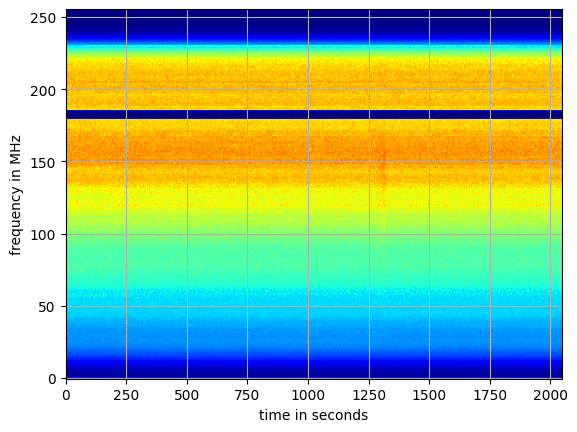

In [31]:
plt.imshow(I_dd.T[:, 143318:145366],cmap='jet', aspect='auto', origin='lower');
plt.xlabel("time in seconds");
plt.ylabel("frequency in MHz");
plt.grid()

In [32]:
folded_tf_I, profile_I = fold_pulsar_data(
    I_dd,     # dedispersed (ntime, nchan)
    period=0.253,
    tsamp=sample_time,
    nbin=2048
)

folded_tf_Q, profile_Q = fold_pulsar_data(
    Q_dd,     # dedispersed (ntime, nchan)
    period=0.253,
    tsamp=sample_time,
    nbin=2048
)

folded_tf_U, profile_U = fold_pulsar_data(
    U_dd,     # dedispersed (ntime, nchan)
    period=0.253,
    tsamp=sample_time,
    nbin=2048
)

folded_tf_V, profile_V = fold_pulsar_data(
    V_dd,     # dedispersed (ntime, nchan)
    period=0.253,
    tsamp=sample_time,
    nbin=2048
)

/tmp/ipykernel_50067/119966499.py:34: UserWarning: Severe phase smearing: 0.50 samples per phase bin (< 1). Reduce nbin or tsamp.
  warnings.warn(


In [33]:
I_k = profile_I - np.mean(profile_I)
Q_k = profile_Q - np.mean(profile_Q)
U_k = profile_U - np.mean(profile_U)
V_k = profile_V - np.mean(profile_V)

rms_I = np.std(I_k)
rms_Q = np.std(Q_k)
rms_U = np.std(U_k)
rms_V = np.std(V_k)

I_SNR = I_k / rms_I
Q_SNR = Q_k / rms_Q
U_SNR = U_k / rms_U
V_SNR = V_k / rms_V

In [34]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'SNR')

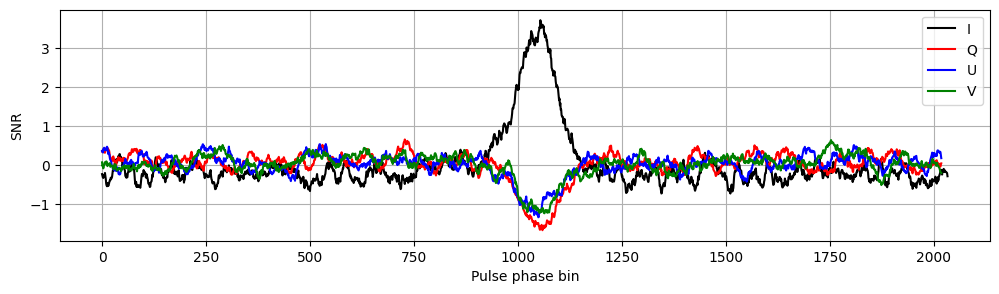

In [35]:
plt.figure(figsize=(12,3))
plt.plot(running_mean(np.roll(I_SNR, -800), 15), label='I', color='black')
plt.plot(running_mean(np.roll(Q_SNR, -800), 30), label='Q', color='red')
plt.plot(running_mean(np.roll(U_SNR, -800), 30), label='U', color='blue')
plt.plot(running_mean(np.roll(V_SNR, -800), 30), label='V', color='green')
plt.grid()
plt.legend()
plt.xlabel("Pulse phase bin")
plt.ylabel("SNR")

# INTRODUCTION TO PSRCHIVE

Unrecognized telescope code (GMRT)


(array([166., 168., 170., 172., 174., 176., 178., 180., 182., 184.]),
 [Text(0, 166.0, '166'),
  Text(0, 168.0, '168'),
  Text(0, 170.0, '170'),
  Text(0, 172.0, '172'),
  Text(0, 174.0, '174'),
  Text(0, 176.0, '176'),
  Text(0, 178.0, '178'),
  Text(0, 180.0, '180'),
  Text(0, 182.0, '182'),
  Text(0, 184.0, '184')])

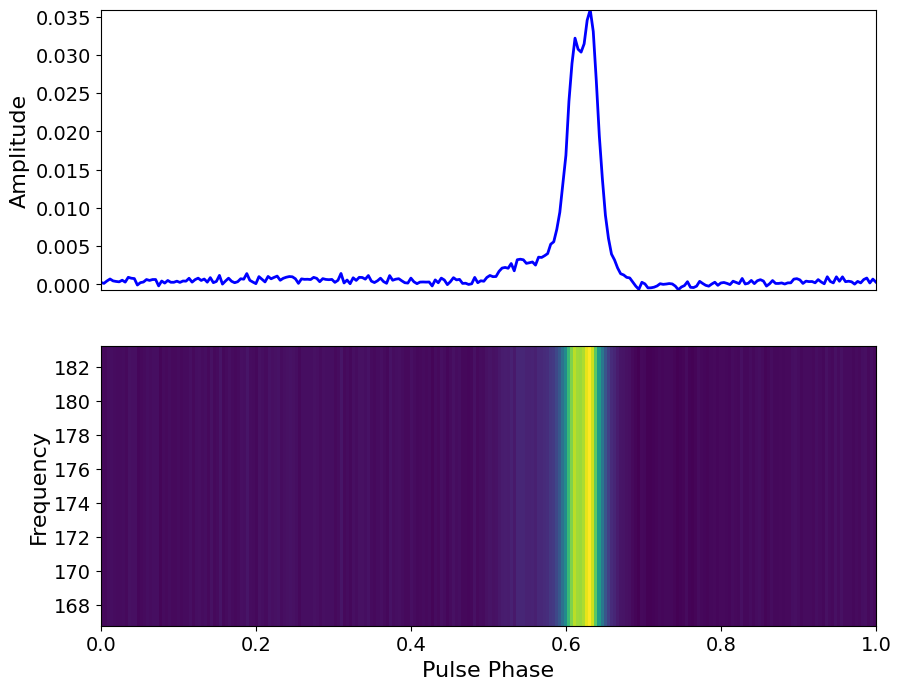

In [36]:
import psrchive
from matplotlib.gridspec import GridSpec

psrfits_file = "J0953+0755_60994.03_175MHz_type_0_GBD_DART.fits_cleaned.t8_Tscrunched.fits"

psr_arch  = psrchive.Archive_load(psrfits_file)

psr_arch.convert_state('Stokes')
psr_arch.dedisperse()
psr_arch.fscrunch()
psr_arch.tscrunch()
psr_arch.remove_baseline()

data = psr_arch.get_data()

nchan      = psr_arch.get_nchan()
npol       = psr_arch.get_npol()
nsubint    = psr_arch.get_nsubint()
nbin       = psr_arch.get_nbin()
mjd        = int(psr_arch.get_mjds()[0])

freq_lo = psr_arch.get_centre_frequency() - psr_arch.get_bandwidth()/2.0
freq_hi = psr_arch.get_centre_frequency() + psr_arch.get_bandwidth()/2.0
#plt.imshow(data[:,0,:,:].mean(0), cmap='jet',extent=(0,1,freq_lo,freq_hi), aspect='auto')

I = data[:,0,:,:].mean(0)
Q = data[:,1,:,:].mean(0)
U = data[:,2,:,:].mean(0)
V = data[:,3,:,:].mean(0)

plt.figure(figsize=(10,8))

plt.subplot(2,1,1)

I_profile = np.mean(I, axis=0)
plt.plot(I_profile, 'b', linewidth=2)
plt.margins(0,0)
#plt.xlabel('Pulse Number', fontsize = 28)
plt.ylabel('Amplitude', fontsize = 16)
#plt.xticks(fontsize = 26)
plt.yticks(fontsize = 14)
#plt.ylim(min(data), max(data) + 0.5)
plt.xticks([])
#plt.grid()

plt.subplot(2,1,2)

plt.imshow(I, aspect='auto', extent =[0,1,freq_hi,freq_lo])
plt.xlabel('Pulse Phase', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)


# Pulse profile across time

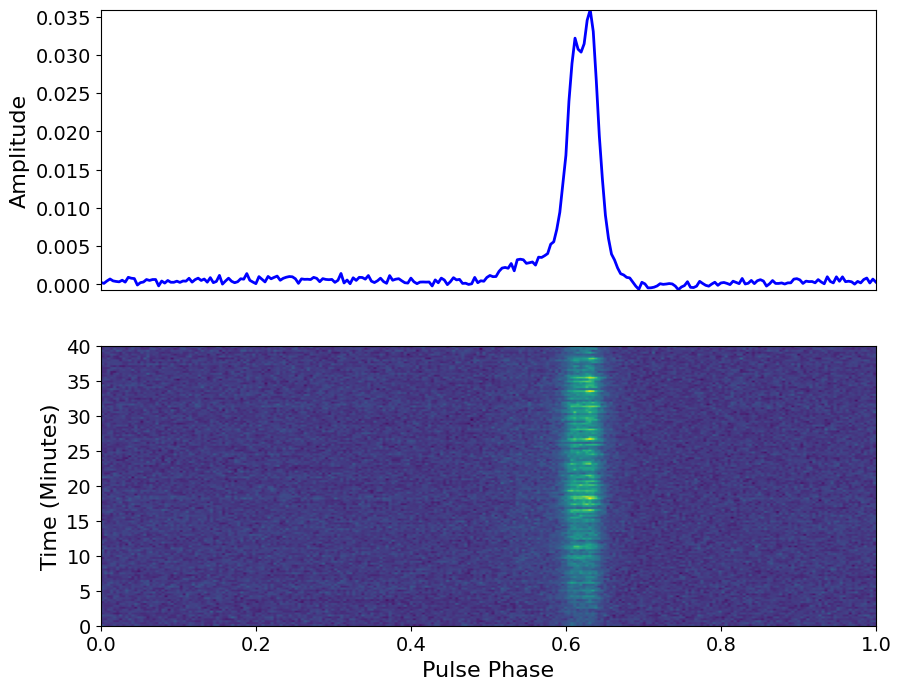

In [38]:
psr_arch_1  = psrchive.Archive_load(psrfits_file)

psr_arch_1.convert_state('Stokes')
psr_arch_1.dedisperse()
psr_arch_1.fscrunch()
#psr_arch_1.tscrunch()
psr_arch_1.remove_baseline()

data_1 = psr_arch_1.get_data()

I_time = data_1[:,0,:,:]
I_time = I_time[:,0]

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)

I_profile = np.mean(I, axis=0)
plt.plot(I_profile, 'b', linewidth=2)
plt.margins(0,0)
#plt.xlabel('Pulse Number', fontsize = 28)
plt.ylabel('Amplitude', fontsize = 16)
#plt.xticks(fontsize = 26)
plt.yticks(fontsize = 14)
#plt.ylim(min(data), max(data) + 0.5)
plt.xticks([])
#plt.grid()

plt.subplot(2,1,2)

plt.imshow(I_time[:-1,:], aspect='auto', extent =[0,1,0,40])
plt.xlabel('Pulse Phase', fontsize = 16)
plt.ylabel('Time (Minutes)', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

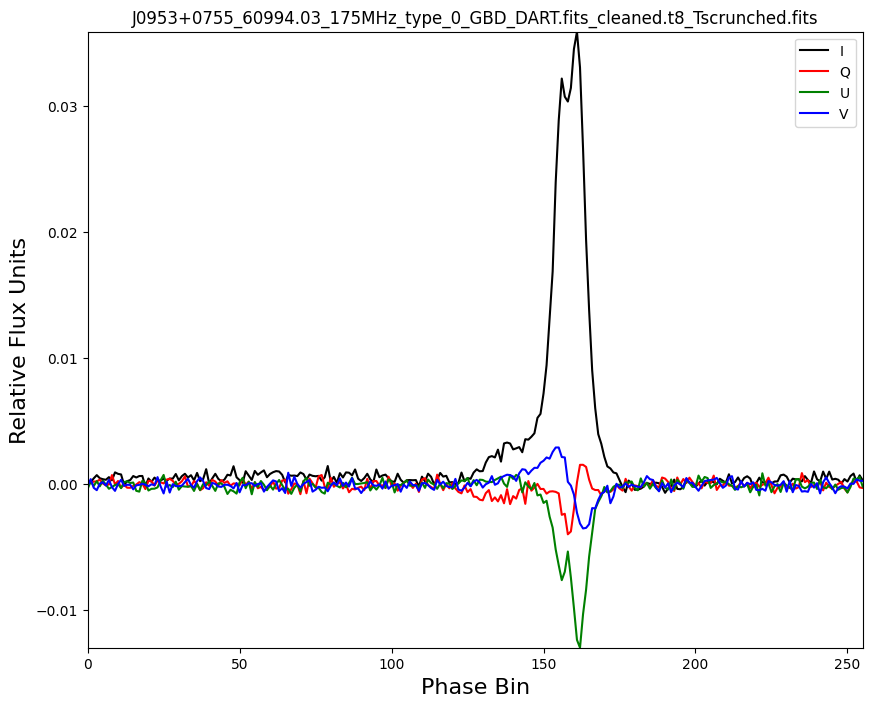

In [39]:
plt.figure(figsize=(10,8))

plt.title(str(psr_arch.get_source()) +'   MJD: ' + str(mjd))

plt.plot(I[0], '-k',label='I')
plt.plot(Q[0], '-r',label='Q')
plt.plot(U[0], '-g',label='U')
plt.plot(V[0], '-b',label='V')
plt.title(psrfits_file.rsplit('/')[-1])

plt.xlabel('Phase Bin', fontsize = 16)
plt.ylabel('Relative Flux Units', fontsize = 16)
plt.legend(loc='best')
plt.margins(0.0)

Text(0, 0.5, 'Frequency (MHz)')

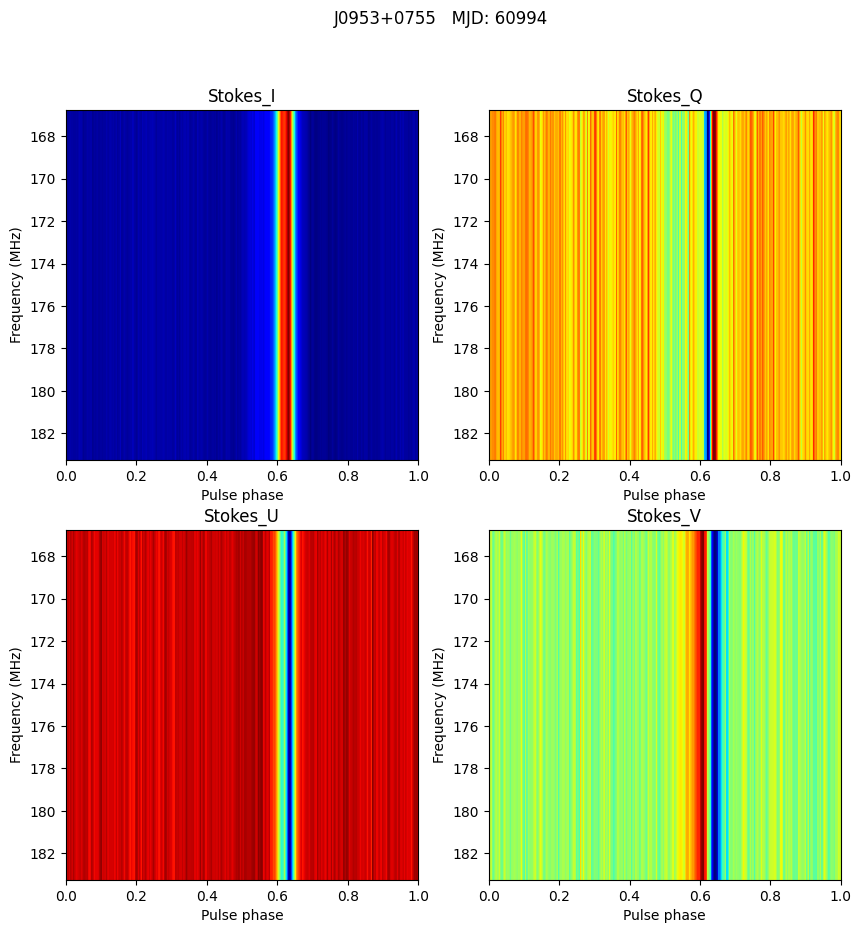

In [40]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.suptitle(str(psr_arch.get_source()) +'   MJD: ' + str(mjd))

plt.imshow(data[:,0,:,:].mean(0), cmap='jet',extent=(0,1,freq_lo,freq_hi), aspect='auto')
plt.gca().set_title('Stokes_I')
plt.xlabel('Pulse phase')
plt.ylabel('Frequency (MHz)')

plt.subplot(2,2,2)
plt.imshow(data[:,1,:,:].mean(0), cmap='jet',extent=(0,1,freq_lo,freq_hi), aspect='auto')
plt.gca().set_title('Stokes_Q')
plt.xlabel('Pulse phase')
plt.ylabel('Frequency (MHz)')

plt.subplot(2,2,3)
plt.imshow(data[:,2,:,:].mean(0), cmap='jet',extent=(0,1,freq_lo,freq_hi), aspect='auto')
plt.gca().set_title('Stokes_U')
plt.xlabel('Pulse phase')
plt.ylabel('Frequency (MHz)')

plt.subplot(2,2,4)
plt.imshow(data[:,3,:,:].mean(0), cmap='jet',extent=(0,1,freq_lo,freq_hi), aspect='auto')
plt.gca().set_title('Stokes_V')
plt.xlabel('Pulse phase')
plt.ylabel('Frequency (MHz)')
